In [47]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

In [48]:
class Value:
    def __init__(self, data, _children=(), _opp="", _label="") -> None:
        self.data = data
        self.prev = _children
        self.opp = _opp
        self.label = _label
        self.grad = 0.0
        self._backward = lambda: None
    
    def __repr__(self) -> str:
        return f"value: ({self.data})"
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        res = Value(self.data+other.data, (self, other), "+")
        def _backward():
            self.grad += res.grad
            other.grad += res.grad
        res._backward = _backward
        return res
    def __radd__(self, other):
        return self+other
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        res = Value(self.data*other.data, (self, other), "*")
        def _backward():
            self.grad += res.grad*other.data
            other.grad += res.grad*self.data
        res._backward = _backward
        return res
    
    def __pow__(self,other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self, ), f"**{other}")
        def _backward():
            self.grad += (other*(self.data**(other-1)))*out.grad
        out._backward = _backward
        return out
    def __rmul__(self, other):
        return self*other
    def __truediv__(self, other):
        return self*(other**-1)
    
    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data-other.data, (self, other), "-")
        def _backward():
            self.grad += out.grad
            other.grad -= out.grad
        out._backward = _backward
        return out
    def __rsub__(self, other):
        return self-other
    def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
        out = Value(t, _children=(self, ), _opp='tanh')
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        n =self.data
        t = math.exp(self.data)
        out = Value(t, _children=(self, ), _opp="exp")
        def _backward():
            self.grad += t*out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for c in v.prev:
                    build_topo(c)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [49]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))

        dot.node(name=uid, label="{%s|data %.4f | grad %.4f}"%(n.label,n.data, n.grad), shape='record')
        if n.opp:
            dot.node(name=uid+n.opp, label=n.opp)
            dot.edge(uid+n.opp, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.opp)
    return dot

In [50]:
x1 = Value(2.0, _label="x1")
x2 = Value(0.0, _label="x2")
w1 = Value(-3.0, _label="w1")
w2 = Value(1.0, _label="w2")
b = Value(6.8813735870195432, _label="b")
x1w1 = x1*w1; x1w1.label = "x1w1"
x2w2 = x2*w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = "x1w1+x2w2"
n = x1w1x2w2+b; n.label = 'n'  
o = n.tanh(); o.label = 'o'
print(o)

value: (0.7071067811865476)


In [51]:
o.backward()

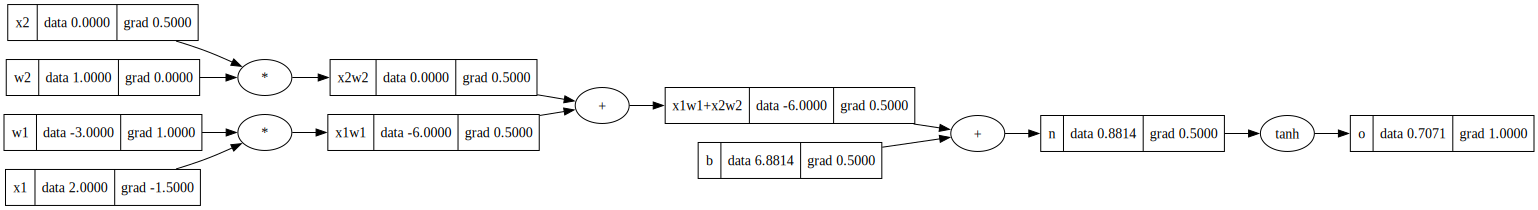

In [52]:
draw_dot(o)

In [53]:
a = Value(2.0)
b = Value(4.0)
print(a-b)

value: (-2.0)


In [54]:
x1 = Value(2.0, _label="x1")
x2 = Value(0.0, _label="x2")
w1 = Value(-3.0, _label="w1")
w2 = Value(1.0, _label="w2")
b = Value(6.8813735870195432, _label="b")
x1w1 = x1*w1; x1w1.label = "x1w1"
x2w2 = x2*w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = "x1w1+x2w2"
n = x1w1x2w2+b; n.label = 'n'  
o = ((2*n).exp()-1)/((2*n).exp()+1); o.label = 'o'
print(o)

value: (0.7071067811865477)


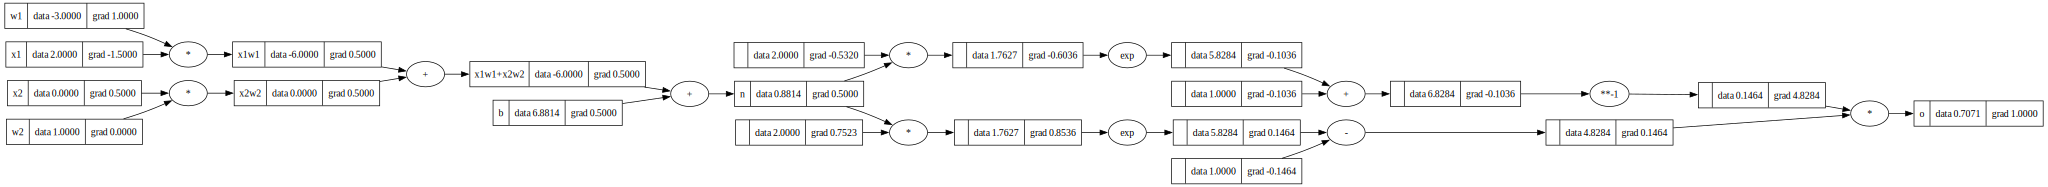

In [55]:
o.backward()
draw_dot(o)

In [56]:
import torch

x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()
print("__________")
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())

0.7071066904050358
__________
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [215]:
from typing import Any

x = [2.0, 3.0, -1.0]
class Neuron:
    def __init__(self, nin) -> None:
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x) -> Any:
       act = sum((wi*xi for wi, xi in zip(self.w, x)), start=self.b)
       out = act.tanh()
       return out
    def parameters(self):
        return self.w+[self.b]

class Layer:
    def __init__(self, nin, nout) -> None:
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [neuron(x) for neuron in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        size = [nin]+nouts
        self.layers = [Layer(size[i], size[i+1])for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

n = MLP(3, [4, 4, 1])
n(x)

value: (0.6158268053707658)

In [216]:
len(n.parameters())

41

In [217]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [1.0, 1.0, -1.0],
    [0.5, 1.0, 1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[value: (0.6158268053707658),
 value: (-0.2905596954442441),
 value: (0.6010622851285492),
 value: (0.5180317760943659)]

In [218]:
loss = sum([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)])
loss

value: (3.4465883989155985)

In [219]:
loss.backward()

In [220]:
n.layers[0].neurons[0].w[0].grad

0.0011356877745743008

In [221]:
for i in range(1000):
    ypred = [n(x) for x in xs]
    loss = sum((ygt - yout)**2 for ygt, yout in zip(ys, ypred))
    for p in n.parameters():
        p.grad = 0.0

    loss.backward()

    for p in n.parameters():
        p.data -= 0.04*p.grad
    if i%10 == 0:
        print(i, loss.data)

0 3.4465883989155985
10 2.610650819372872
20 2.0314856885376837
30 0.5140475399616891
40 0.13423216475341274
50 0.06295068967232838
60 0.03845794567590009
70 0.026849562488034568
80 0.020277239050604266
90 0.016119350021876977
100 0.013282643973583065
110 0.01123883589441734
120 0.00970440370726798
130 0.008514753856817285
140 0.007568324508627653
150 0.006799316357065767
160 0.006163366207921586
170 0.005629553940966781
180 0.005175715364457861
190 0.004785575964573155
200 0.004446934261290681
210 0.004150474229961782
220 0.0038889677043365935
230 0.0036567258055361673
240 0.0034492135991838796
250 0.0032627742598302168
260 0.003094428247864207
270 0.0029417248427967544
280 0.002802630845600786
290 0.0026754460791873465
300 0.002558738484545932
310 0.0024512937326850955
320 0.002352075718386251
330 0.0022601953019018755
340 0.0021748853663719767
350 0.002095480757472441
360 0.0020214020306578446
370 0.0019521421925010989
380 0.0018872558146874284
390 0.001826350041870879
400 0.0017690

In [222]:

print(ypred)

[value: (0.982809442564373), value: (-0.9984260362774022), value: (-0.9841304366767996), value: (0.993471419257607)]
